# 1. Импорт необходимых библиотек и модулей

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

# print("TensorFlow version:", tf.__version__)

%matplotlib inline

# 2. Чтение данных из файла
## 2.1 Чтение экспериментальных данных из .csv

In [2]:
file_name = 'test.csv'

# TIME_CONSTANT = 0.005
# AMPL = 3.0
# F_PULSE = 20 * 10 ** (-6)
# STDDEV = 0.2

In [3]:
data = pd.read_csv(file_name, 
                   header = 0
                  )

data['temperature_k'] = 298.0
data = data[['f_pulse', 'temperature_k', 'frequency_hz', 'dlts_pf']]

data.head()

,f_pulse,temperature_k,frequency_hz,dlts_pf
0,0.00002,298.0,1.000000,0.024528
1,0.00002,298.0,1.007863,-0.200976
2,0.00002,298.0,1.015787,0.004056
3,0.00002,298.0,1.023774,0.252659
4,0.00002,298.0,1.031823,0.307020


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   f_pulse        1000 non-null   float64
 1   temperature_k  1000 non-null   float64
 2   frequency_hz   1000 non-null   float64
 3   dlts_pf        1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


## 2.2 Подготовка данных для TensorFlow

In [5]:
data = tf.Variable(data, dtype = 'float64')
data

<tf.Variable 'Variable:0' shape=(1000, 4) dtype=float64, numpy=
array([[ 2.00000000e-05,  2.98000000e+02,  1.00000000e+00,
         2.45275890e-02],
       [ 2.00000000e-05,  2.98000000e+02,  1.00786263e+00,
        -2.00976060e-01],
       [ 2.00000000e-05,  2.98000000e+02,  1.01578708e+00,
         4.05599600e-03],
       ...,
       [ 2.00000000e-05,  2.98000000e+02,  2.46114571e+03,
         4.04702250e-01],
       [ 2.00000000e-05,  2.98000000e+02,  2.48049678e+03,
         3.30266360e-01],
       [ 2.00000000e-05,  2.98000000e+02,  2.50000000e+03,
         1.45875320e-01]])>

- Столбец `data`, содержащий значения имульса заполнения `data[:,0]`
- Столбец `data`, содержащий значения температуры `data[:,1]`
- Столбец `data`, содержащий значения частоты импульсов заполнения `data[:,2]`
- Столбец `data`, содержащий значения сигнала DLTS в пФ `data[:,3]`

In [6]:
data[:10,0]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05,
       2.e-05, 2.e-05])>

In [7]:
data[:10,1]

<tf.Tensor: shape=(10,), dtype=float64, numpy=array([298., 298., 298., 298., 298., 298., 298., 298., 298., 298.])>

In [8]:
data[:10,2]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([1.        , 1.00786263, 1.01578708, 1.02377383, 1.03182338,
       1.03993623, 1.04811286, 1.05635378, 1.06465949, 1.07303051])>

In [9]:
data[:10,3]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.02452759, -0.20097606,  0.004056  ,  0.2526595 ,  0.30702022,
       -0.0514327 ,  0.02464598, -0.24007213, -0.07533233, -0.05187012])>

## 2.3 График

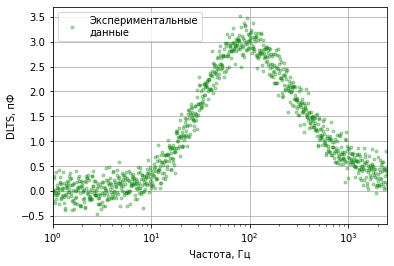

In [10]:
plt.semilogx(data[:,2].numpy(), data[:,3].numpy(), '.g', label='Экспериментальные\nданные', alpha = 0.3)
plt.grid()
plt.xlim([1, 2500])
# plt.ylim([-0.006, 0])
plt.legend()
plt.ylabel('DLTS, пФ')
plt.xlabel('Частота, Гц')
plt.show()

## 2.4 Подготовка данных
### 2.4.1 Переход к десятичному логарифму частоты

In [11]:
data[:,2].assign(tf.math.log(data[:,2])/tf.math.log(tf.Variable(10, dtype='float64')))
data[:10,2]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.        , 0.00340134, 0.00680268, 0.01020402, 0.01360537,
       0.01700671, 0.02040805, 0.02380939, 0.02721073, 0.03061207])>

### 2.4.2 Нормализация значений сигнала DLTS

In [12]:
# scale_factor = tf.reduce_max(data[:,2]) / (tf.reduce_max(data[:,3]) - tf.reduce_min(data[:,3]))
# data[:,3].assign(data[:,3] * scale_factor)
# data[:10,3]

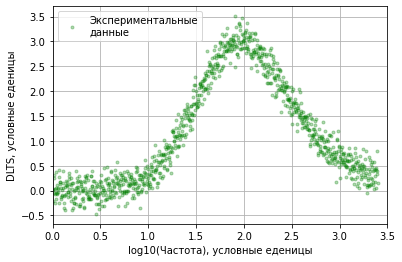

In [13]:
plt.plot(data[:,2].numpy(), data[:,3].numpy(), '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

# 3. Описание модели
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ -- масштабный множитель.

$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

# 4. Кодирование модели
$$ \tau = 10^{time\_constant\_power} $$

$$ F_0 = 10^{frequency\_power}$$

$$ a = \tau F_0 $$

$$ b = t_1 F_0 $$

$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$

$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$

$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$

$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$

$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

$$  M = \frac{1}{\max{\left[
    a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right)
    \right]}}
$$

$$ S\left(\tau, A, F_0, t_1, p\right) = A\left[\phi\left(\tau,F_0,t_1\right)\right]^p $$

In [14]:
class FrequencyScan(tf.Module):
    
    def get_phi(self, 
                frequency_powers):

        time_constant = tf.pow(10.0, self.time_constant_power)
        frequency = tf.pow(10.0, frequency_powers)

        a = time_constant * frequency
        b = self.filling_pulse * frequency

        exp0 = tf.exp(-0.05 / (a))
        exp1 = tf.exp((b - 0.45) / (a))
        exp2 = tf.exp(-0.5 / (a))
        exp3 = tf.exp((b - 0.95) / (a))

        return a * exp0 * (1.0 - exp1 - exp2 + exp3)


    def get_M(self,
              learning_rate=0.1,
              n_iters=100,
              stop_val = None,
             ):

        prev_loss = tf.Variable(np.inf, dtype='float64')
        max_freq_pow = tf.Variable(-self.time_constant_power, dtype='float64')

        for _ in range(n_iters):
            with tf.GradientTape() as tape:

                current_loss = 0.0 - self.get_phi(max_freq_pow)

            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break

            dfreq_pow = tape.gradient(current_loss, max_freq_pow)
            max_freq_pow.assign_sub(learning_rate * dfreq_pow)

            prev_loss = current_loss

        return 1 / self.get_phi(max_freq_pow)
    
    
    def __init__(self,
                 amplitude = 3.5,
                 time_constant_power = -2.0,
                 filling_pulse = 20*10**-6,
                 p_coef = 1.0,
                 
                 fit_p_coef = True,
                 learning_rate = 0.1,
                 n_iters = 1000,
                 stop_val = None,
                 verbose = False,
                 
                 **kwargs
                ):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        self.time_constant_power = tf.Variable(time_constant_power, dtype='float64')
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        self.p_coef = tf.Variable(p_coef, dtype='float64')
        
        self.fit_p_coef = fit_p_coef
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.stop_val = stop_val
        self.verbose = verbose
        
        
    def __call__(self, frequency_powers):
        
        M = self.get_M(learning_rate=0.2,
                       n_iters=100,
                       stop_val = 10**-10)
        
        phi = self.get_phi(frequency_powers)
        
        return self.amplitude * tf.pow(M * phi, self.p_coef)
    
    
    def fit(self,
            frequency_powers,
            dlts,
           ):
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        fit_results = pd.DataFrame(columns=['amplitude', 'time_constant_power', 'p_coef', 'loss'])
        
        for _ in range(self.n_iters):
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_powers)
                current_loss = tf.reduce_mean(tf.square(dlts - predicted_dlts))
                
            if self.fit_p_coef:
                dampl, dtime_const_pow, dp_coef = tape.gradient(current_loss, [self.amplitude, 
                                                                               self.time_constant_power,
                                                                               self.p_coef
                                                                              ]
                                                               )
            else:
                dampl, dtime_const_pow = tape.gradient(current_loss, [self.amplitude, 
                                                                      self.time_constant_power
                                                                     ]
                                                      )
                
            fit_results.loc[_, 'amplitude'] = self.amplitude.numpy()
            fit_results.loc[_, 'time_constant_power'] = self.time_constant_power.numpy()
            fit_results.loc[_, 'p_coef'] = self.p_coef.numpy()
            fit_results.loc[_, 'loss'] = current_loss.numpy()     
            
            if self.verbose:
                print('iter #', _)
                print('amp:',self.amplitude)
                print('tau:',self.time_constant_power)
                print('p:', self.p_coef)
                print('Loss:', current_loss)
                
            self.amplitude.assign_sub(self.learning_rate * dampl)
            self.time_constant_power.assign_sub(self.learning_rate * dtime_const_pow)
            if self.fit_p_coef:
                self.p_coef.assign_sub(self.learning_rate * dp_coef)
                
            if self.stop_val is not None:
                if tf.abs(current_loss - prev_loss) < self.stop_val:
                    break
                    
            prev_loss = current_loss
            
        return fit_results

# 5. Проверка модели
## 5.1 Идентификация без изменения $p$

In [15]:
fs = FrequencyScan(fit_p_coef = False,
                   learning_rate = 0.2,
                   n_iters = 1000,
                   stop_val = 10**-10,
                   verbose = True)

initial_dlts = fs(data[:,2])

In [16]:
fit_results = fs.fit(data[:,2], data[:,3])

iter # 0
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.5>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.0>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.5467947739608965, shape=(), dtype=float64)
iter # 1
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.420822497077624>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.558189614292208>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.39972027843267505, shape=(), dtype=float64)
iter # 2
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.3593813999403945>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.0885737495966823>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.2889885710701849, shape=(), dtype=float64)
iter # 3
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.3075527966474074>
tau: <tf.Variable 'Variable:0' shape=() dtype=floa

iter # 28
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0110592758485706>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.299964528907764>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.03777093037416606, shape=(), dtype=float64)
iter # 29
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0093169739158787>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3009978300902834>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.037755937606584425, shape=(), dtype=float64)
iter # 30
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.007761359949611>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.300209106938807>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.0377440686259067, shape=(), dtype=float64)
iter # 31
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.006365953860682>
tau: <tf.Variabl

iter # 56
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9952143013919605>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3005180697473215>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.0376973902750623, shape=(), dtype=float64)
iter # 57
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9951360986776088>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3005182281489835>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.03769736130058692, shape=(), dtype=float64)
iter # 58
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.995066098890735>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3005178131486015>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.0376973380848776, shape=(), dtype=float64)
iter # 59
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.995003439507405>
tau: <tf.Variabl

In [17]:
fit_results

,amplitude,time_constant_power,p_coef,loss
0,3.5,-2.0,1.0,0.546795
1,3.420822,-2.55819,1.0,0.39972
2,3.359381,-2.088574,1.0,0.288989
3,3.307553,-2.485712,1.0,0.223718
4,3.266041,-2.145635,1.0,0.170693
...,...,...,...,...
79,2.994527,-2.300517,1.0,0.037697
80,2.994521,-2.300517,1.0,0.037697
81,2.994515,-2.300517,1.0,0.037697
82,2.99451,-2.300517,1.0,0.037697


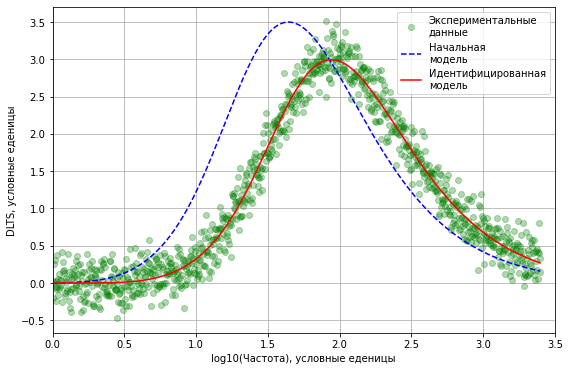

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(data[:,2].numpy(), data[:,3].numpy(), 'og', label='Экспериментальные\nданные', alpha=0.3)
ax.plot(data[:,2].numpy(), initial_dlts.numpy(), '--b', label='Начальная\nмодель', alpha=1)
ax.plot(data[:,2].numpy(), fs(data[:,2]).numpy(), '-r', label='Идентифицированная\nмодель', alpha=1)
ax.grid()
ax.set_xlim([0, 3.5])
# plt.ylim([-3.5, 0])
ax.legend()
ax.set_ylabel('DLTS, условные еденицы')
ax.set_xlabel('log10(Частота), условные еденицы')
plt.show()

In [19]:
x = np.linspace(2, 4, 40)
y = np.linspace(-3, -1, 40)

X, Y = np.meshgrid(x, y)

# def get_mse(X, Y, freq, dlts):
    
#     x = X.flatten()
#     y = Y.flatten()
    
#     mse = np.zeros(shape=(x.shape[0]))
    
#     for i in range(x.shape[0]):
#         amp = tf.Variable(x[i], dtype='float64')
#         time_const = tf.Variable(y[i], dtype='float64')
        
#         fs = FrequencyScan(amplitude = amp,
#                            time_constant_power = time_const,
#                            filling_pulse = 20*10**-6,
#                            p_coef = 1.0)
#         mse[i] = tf.reduce_mean(tf.square(dlts - fs(freq))).numpy()

#         print(i, x[i], y[i], mse[i])
        
#     return np.reshape(mse, X.shape)


# https://joblib.readthedocs.io/en/latest/parallel.html#parallel

x = X.flatten()
y = Y.flatten()

n_jobs = 8

chunks_x = np.split(x, n_jobs)
chunks_y = np.split(y, n_jobs)

def get_mse(x, y, freq, dlts):

    mse = np.zeros(shape=(x.shape[0]))

    for i in range(x.shape[0]):
        amp = tf.Variable(x[i], dtype='float64')
        time_const = tf.Variable(y[i], dtype='float64')

        fs = FrequencyScan(amplitude = amp,
                           time_constant_power = time_const,
                           filling_pulse = 20*10**-6,
                           p_coef = 1.0)
        mse[i] = tf.reduce_mean(tf.square(dlts - fs(freq))).numpy()

#         print(i, x[i], y[i], mse[i])

    return mse

from joblib import Parallel, delayed
Z = Parallel(n_jobs=n_jobs)(delayed(get_mse)(chunks_x[i], chunks_y[i], data[:,2], data[:,3]) for i in range(n_jobs))
Z = np.reshape(np.c_[Z].flatten(), X.shape)

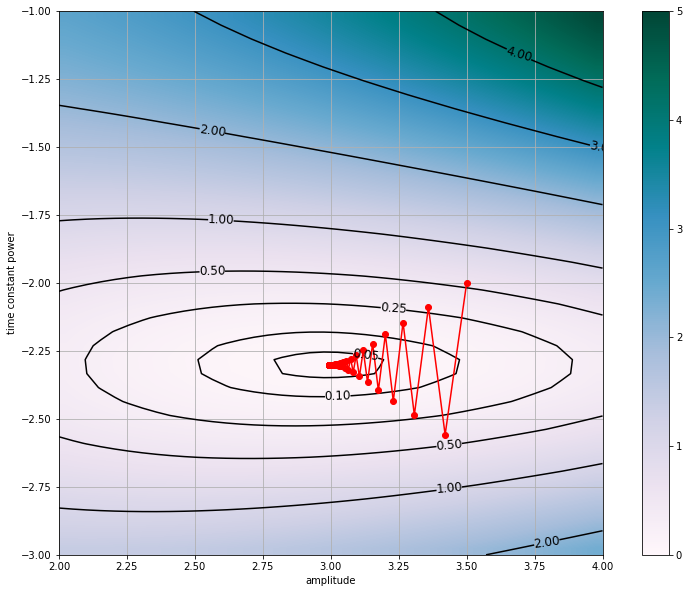

In [20]:
fig, ax = plt.subplots(figsize=(14,10))
CS = ax.contour(X, Y, Z, 
                levels=[0, 0.05, 0.1, 0.25, 0.5, 1, 2.0, 3.0, 4.0, 5.0], 
                colors='k')
ax.clabel(CS, 
          inline=True, 
          fontsize=12)

IM = ax.imshow(Z, 
               interpolation='bilinear', 
               origin='lower',
               cmap=cm.PuBuGn, 
               extent=(2, 4, -3, -1), 
               vmin=0, 
               vmax=np.round(Z.max()))

ax.plot(fit_results.amplitude.to_numpy(), fit_results.time_constant_power.to_numpy(), 'o-r')
# ax.set_title('Simplest default with labels')
fig.colorbar(IM, shrink=1)

ax.set_xlabel('amplitude')
ax.set_ylabel('time constant power')
plt.grid()
plt.show()

In [21]:
fs = FrequencyScan(amplitude = 2.25,
                   time_constant_power = -1.5,
                   filling_pulse = 20*10**-6,
                   p_coef = 1.0,
    
                   fit_p_coef = False,
                   learning_rate = 0.2,
                   n_iters = 1000,
                   stop_val = 10**-10,
                   verbose = True)

initial_dlts = fs(data[:,2])

fit_results = fs.fit(data[:,2], data[:,3])

iter # 0
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.25>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-1.5>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(1.7043999192868227, shape=(), dtype=float64)
iter # 1
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.191943985132002>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.0358654797942544>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.4204697854716231, shape=(), dtype=float64)
iter # 2
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.25608697617792>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.348944046251834>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.18890756898633668, shape=(), dtype=float64)
iter # 3
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.332948408464246>
tau: <tf.Variable 'Variable:0' shape=() dtype=float6

iter # 28
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9530028202626157>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.300420865526963>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.038148064681128295, shape=(), dtype=float64)
iter # 29
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.957351632623661>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3004308254710706>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.03805846194257478, shape=(), dtype=float64)
iter # 30
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.961244353525235>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3004398785318396>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.037986668205208095, shape=(), dtype=float64)
iter # 31
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9647288172313626>
tau: <tf.Vari

iter # 56
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9926048100038787>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3005122432015863>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.03769815532556635, shape=(), dtype=float64)
iter # 57
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.992800283260291>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3005126941761844>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.03769797429381522, shape=(), dtype=float64)
iter # 58
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9929752558949008>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.300513097882809>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.037697829242951425, shape=(), dtype=float64)
iter # 59
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9931318779489833>
tau: <tf.Vari

iter # 84
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9943848687976726>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.300516350019557>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.037697246335121136, shape=(), dtype=float64)
iter # 85
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9943936550852843>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.300516370290101>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.03769724596936564, shape=(), dtype=float64)
iter # 86
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9944015198947453>
tau: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.3005163884347395>
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.03769724567630564, shape=(), dtype=float64)
iter # 87
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.99440855986778>
tau: <tf.Variab

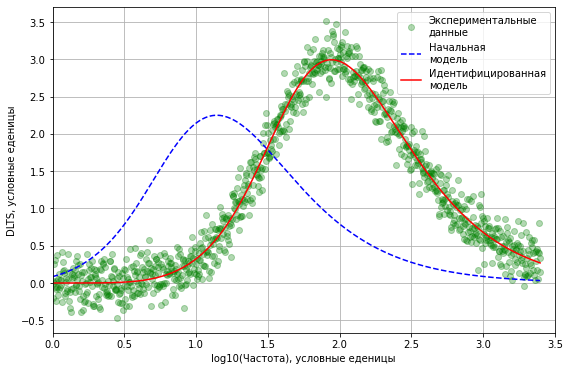

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(data[:,2].numpy(), data[:,3].numpy(), 'og', label='Экспериментальные\nданные', alpha=0.3)
ax.plot(data[:,2].numpy(), initial_dlts.numpy(), '--b', label='Начальная\nмодель', alpha=1)
ax.plot(data[:,2].numpy(), fs(data[:,2]).numpy(), '-r', label='Идентифицированная\nмодель', alpha=1)
ax.grid()
ax.set_xlim([0, 3.5])
# plt.ylim([-3.5, 0])
ax.legend()
ax.set_ylabel('DLTS, условные еденицы')
ax.set_xlabel('log10(Частота), условные еденицы')
plt.show()

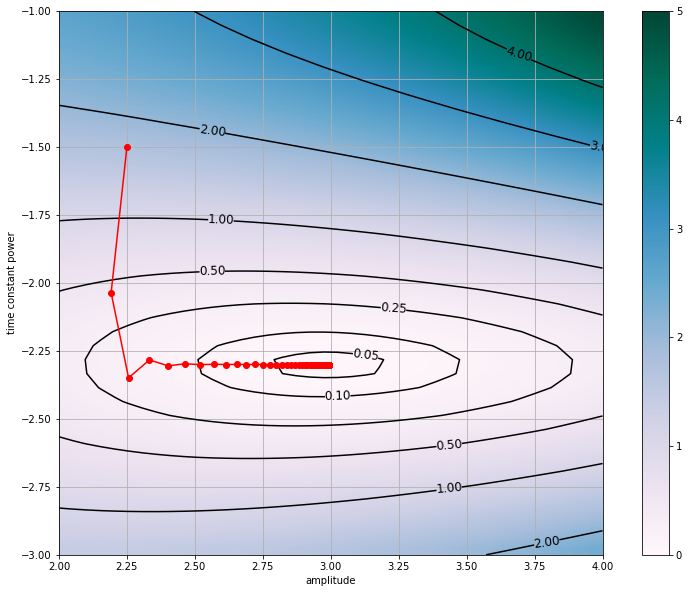

In [23]:
fig, ax = plt.subplots(figsize=(14,10))
CS = ax.contour(X, Y, Z, 
                levels=[0, 0.05, 0.1, 0.25, 0.5, 1, 2.0, 3.0, 4.0, 5.0], 
                colors='k')
ax.clabel(CS, 
          inline=True, 
          fontsize=12)

IM = ax.imshow(Z, 
               interpolation='bilinear', 
               origin='lower',
               cmap=cm.PuBuGn, 
               extent=(2, 4, -3, -1), 
               vmin=0, 
               vmax=np.round(Z.max()))

ax.plot(fit_results.amplitude.to_numpy(), fit_results.time_constant_power.to_numpy(), 'o-r')
# ax.set_title('Simplest default with labels')
fig.colorbar(IM, shrink=1)

ax.set_xlabel('amplitude')
ax.set_ylabel('time constant power')
plt.grid()
plt.show()

## 5.2 Идентификация модели с идентификацией коэффицента $p$

In [24]:
fs = FrequencyScan(fit_p_coef = True,
                   learning_rate = 0.2,
                   n_iters = 1000,
                   stop_val = 10**-10,
                   verbose = False)

initial_dlts = fs(data[:,2])

In [25]:
fit_results = fs.fit(data[:,2], data[:,3])

In [26]:
fit_results

,amplitude,time_constant_power,p_coef,loss
0,3.5,-2.0,1.0,0.546795
1,3.420822,-2.55819,1.028348,0.397655
2,3.362077,-2.084218,1.040202,0.294255
3,3.313444,-2.493721,1.056057,0.235831
4,3.275619,-2.132889,1.061626,0.187035
...,...,...,...,...
144,3.006736,-2.300405,1.015201,0.037627
145,3.006732,-2.300405,1.015198,0.037627
146,3.006728,-2.300405,1.015196,0.037627
147,3.006724,-2.300405,1.015193,0.037627


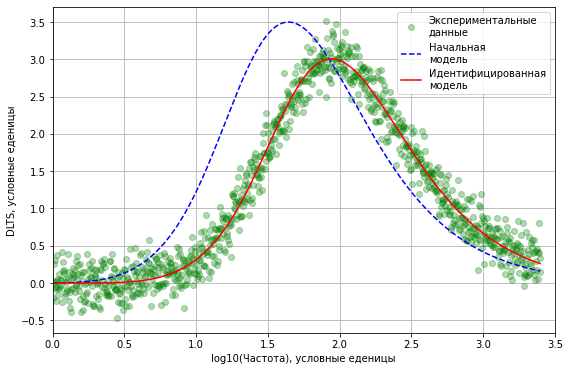

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(data[:,2].numpy(), data[:,3].numpy(), 'og', label='Экспериментальные\nданные', alpha=0.3)
ax.plot(data[:,2].numpy(), initial_dlts.numpy(), '--b', label='Начальная\nмодель', alpha=1)
ax.plot(data[:,2].numpy(), fs(data[:,2]).numpy(), '-r', label='Идентифицированная\nмодель', alpha=1)
ax.grid()
ax.set_xlim([0, 3.5])
# plt.ylim([-3.5, 0])
ax.legend()
ax.set_ylabel('DLTS, условные еденицы')
ax.set_xlabel('log10(Частота), условные еденицы')
plt.show()

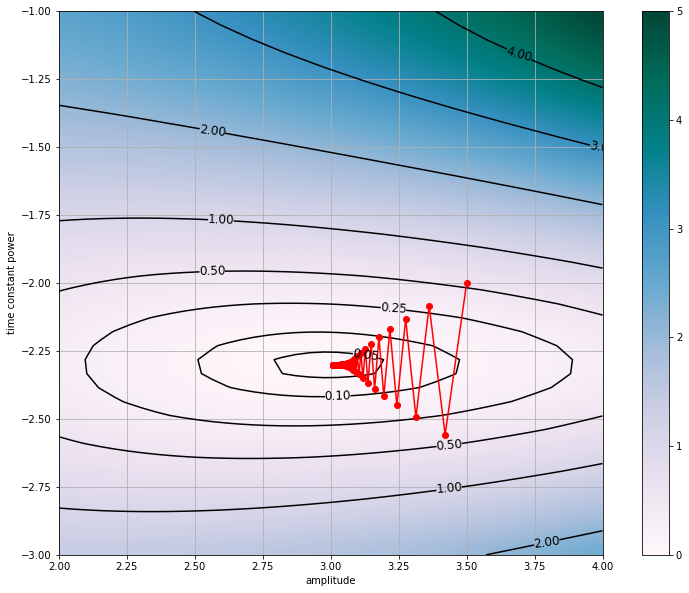

In [28]:
fig, ax = plt.subplots(figsize=(14,10))
CS = ax.contour(X, Y, Z, 
                levels=[0, 0.05, 0.1, 0.25, 0.5, 1, 2.0, 3.0, 4.0, 5.0], 
                colors='k')
ax.clabel(CS, 
          inline=True, 
          fontsize=12)

IM = ax.imshow(Z, 
               interpolation='bilinear', 
               origin='lower',
               cmap=cm.PuBuGn, 
               extent=(2, 4, -3, -1), 
               vmin=0, 
               vmax=np.round(Z.max()))

ax.plot(fit_results.amplitude.to_numpy(), fit_results.time_constant_power.to_numpy(), 'o-r')
# ax.set_title('Simplest default with labels')
fig.colorbar(IM, shrink=1)

ax.set_xlabel('amplitude')
ax.set_ylabel('time constant power')
plt.grid()
plt.show()